In [28]:
#SYSTEM 
import subprocess

def run_gnina(protein,ligand,center_x,center_y,center_z,size_x,size_y,size_z):
    cmd=[
    "./gnina",   
    #      "--config",box_file,
                "--center_x",str(center_x),
    "--center_y",str(center_y),
    "--center_z",str(center_z),
    "--size_x",str(size_x),
    "--size_y",str(size_y),
    "--size_z",str(size_z),
    # "--cnn_center_x",center_x,
    # "--cnn_center_y",center_y,
    # "--cnn_center_z",center_z,
    # "--minimize", 
    #      "--log","test.log",
    "--num_mc_saved", str(1),
    "--num_modes", str(1),  
    "--seed", str(42),
    "--autobox_extend", str(1),
    "--exhaustiveness", str(8),
            "--cnn_scoring","rescore",
            "--verbosity=0",
    "-r", str(protein),
    "-l", f'ligands/{ligand}.pdb',
    "--out" , f"results/{ligand}.pdb"
        ] 
    result=subprocess.run(cmd,stdout=subprocess.PIPE  )
  #  return result.stdout.decode('utf-8')

def read_box_file(box_file):
    with open(box_file) as f:
        lines=f.readlines()
    center_x = lines[0].split('=')[1].strip()
    center_y = lines[1].split('=')[1].strip()
    center_z = lines[2].split('=')[1].strip()
    size_x = lines[3].split('=')[1].strip()
    size_y = lines[4].split('=')[1].strip()
    size_z = lines[5].split('=')[1].strip()
    # convert to float
    center_x = float(center_x)
    center_y = float(center_y)
    center_z = float(center_z)
    size_x = float(size_x)
    size_y = float(size_y)
    size_z = float(size_z)
    

    return center_x,center_y,center_z,size_x,size_y,size_z


In [29]:
#INIT
init_smiles='O=C(C1=CC=CC=C1)NCCN1CCN(CC1)C1=CC=CC=C1'

from rdkit import Chem
from rdkit.Chem import AllChem

m = Chem.MolFromSmiles(init_smiles)
m = Chem.AddHs(m)
AllChem.EmbedMolecule(m)
AllChem.MMFFOptimizeMolecule(m)
Chem.MolToPDBFile(m,'ligands/ligand.pdb')

In [30]:
center_x,center_y,center_z,size_x,size_y,size_z=read_box_file('P22680_3V8D_A_box_2.txt')
run_gnina('P22680_3V8D_A.pdb','ligand',center_x,center_y,center_z,size_x,size_y,size_z)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



In [31]:
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport
import pandas as pd

In [193]:
# INIT DockingStatistics
from plip.basic import config
from plip.structure.preparation import PDBComplex
from Bio.PDB import PDBParser

def atoms_in_bounding_box(pdb_file, center, size):
    """
    List all atom indices in a given bounding box defined by its center and size.
    
    :param pdb_file: Path to the PDB file
    :param center: A tuple of coordinates for the bounding box center (center_x, center_y, center_z)
    :param size: A tuple of sizes along each axis for the bounding box (size_x, size_y, size_z)
    :return: List of atom indices within the bounding box
    """
    center_x, center_y, center_z = center
    size_x, size_y, size_z = size
    
    # Calculate bounding box coordinates
    xmin = center_x - size_x / 2
    xmax = center_x + size_x / 2
    ymin = center_y - size_y / 2
    ymax = center_y + size_y / 2
    zmin = center_z - size_z / 2
    zmax = center_z + size_z / 2
    
    # Load the PDB file
    parser = PDBParser()
    structure = parser.get_structure('protein', pdb_file)
    
    # Iterate through all atoms and check if they lie within the bounding box
    atom_indices = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    # check if it's a carbon atom
                    if atom.element != 'C':
                        continue
                    x, y, z = atom.coord
                    if xmin <= x <= xmax and ymin <= y <= ymax and zmin <= z <= zmax:
                        atom_indices.append(atom.serial_number)
    
    return atom_indices

# Example usage
pdb_file = 'P22680_3V8D_A.pdb'
center = (center_x, center_y, center_z)
size = (size_x, size_y, size_z)
atom_indices = atoms_in_bounding_box(pdb_file, center, size)


In [ ]:
#COMPUTE STATISTICS

In [6]:
def merge_pdb_files_with_hetatm(ligand_file, protein_file, output_file):
    # Read the ligand PDB file
    with open(ligand_file, 'r') as file:
        ligand_content = file.readlines()

    # Read the protein PDB file
    with open(protein_file, 'r') as file:
        protein_content = file.readlines()

    # Separate the ATOM and HETATM lines for protein and ligand
    protein_atoms = [line for line in protein_content if line.startswith('ATOM')]
    protein_hetatms = [line for line in protein_content if line.startswith('HETATM')]
    ligand_hetatms = [line for line in ligand_content if line.startswith('HETATM')]

    # Add MODEL and ENDMDL lines to the protein content if they don't exist
    if not protein_content[0].startswith('MODEL'):
        protein_content.insert(0, 'MODEL        1\n')
        protein_content.append('ENDMDL\n')

    # Combine the protein ATOM, protein HETATM, and ligand HETATM contents
    combined_content = protein_atoms + protein_hetatms + ligand_hetatms

    # Ensure the combined content ends with END line
    if not combined_content[-1].strip() == 'END':
        combined_content.append('END\n')

    # Write the combined content to the output PDB file
    with open(output_file, 'w') as file:
        file.writelines(combined_content)


# Define the file paths
ligand_pdb = 'results/ligand.pdb'
protein_pdb = 'P22680_3V8D_A.pdb'
complex_pdb = 'complex.pdb'

# Merge the PDB files with HETATM separation
merge_pdb_files_with_hetatm(ligand_pdb, protein_pdb, complex_pdb)

print(f"Merged {ligand_pdb} and {protein_pdb} into {complex_pdb}")



Merged results/ligand.pdb and P22680_3V8D_A.pdb into complex.pdb


In [54]:
def retrieve_plip_interactions(pdb_file):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(pdb_file)  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions

    key, site = sorted(protlig.interaction_sets.items())[0]

    binding_site = BindingSiteReport(site) 

    return getattr(binding_site, "hydrophobic_info")

In [68]:
# 'RESNR',
# 'RESTYPE',
# 'RESCHAIN',
# 'RESNR_LIG',
# 'RESTYPE_LIG',
# 'RESCHAIN_LIG',
# 'DIST',
# 'LIGCARBONIDX',
# 'PROTCARBONIDX',
# 'LIGCOO',
# 'PROTCOO'
interactions_by_site=retrieve_plip_interactions('complex.pdb')
# retrieve PROTCARBONIDX
protcarbonidxs=[ i[8] for i in interactions_by_site]
dists=[ i[6] for i in interactions_by_site]

In [75]:
# internsection with atom_indices
statistics=[
    1/float(dists[protcarbonidxs.index(a)]) if a in protcarbonidxs else 0
    for a in atom_indices
]

[C+1]=[P+1]=[B-1]=O


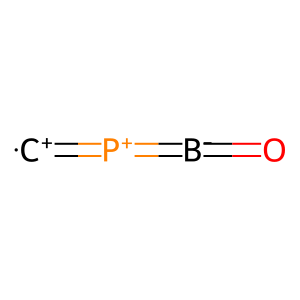

In [176]:
import selfies as sf
import random

alphabet=sf.get_semantic_robust_alphabet() # Gets the alphabet of robust symbols
rnd_selfies=''.join(random.choices(list(alphabet), k=100))
rnd_smiles=sf.decoder(rnd_selfies)
print(rnd_smiles)
# plot smiles
from rdkit import Chem
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(rnd_smiles)
Draw.MolToImage(m)

In [140]:
sf.encoder("C1=CC=CC=C1")

'[C][=C][C][=C][C][=C][Ring1][=Branch1]'

In [177]:
organic_chemistry_probabilities = {
    '[#B-1]': 0.01,
    '[#B]': 0.02,
    '[#Branch1]': 0.05,
    '[#Branch2]': 0.03,
    '[#Branch3]': 0.02,
    '[#C+1]': 0.01,
    '[#C-1]': 0.03,
    '[#C]': 0.30,
    '[#N+1]': 0.01,
    '[#N]': 0.05,
    '[#O+1]': 0.01,
    '[#P+1]': 0.005,
    '[#P-1]': 0.005,
    '[#P]': 0.02,
    '[#S+1]': 0.01,
    '[#S-1]': 0.01,
    '[#S]': 0.04,
    '[=B+1]': 0.005,
    '[=B-1]': 0.005,
    '[=B]': 0.01,
    '[=Branch1]': 0.03,
    '[=Branch2]': 0.02,
    '[=Branch3]': 0.01,
    '[=C+1]': 0.005,
    '[=C-1]': 0.01,
    '[=C]': 0.25,
    '[=N+1]': 0.005,
    '[=N-1]': 0.005,
    '[=N]': 0.03,
    '[=O+1]': 0.005,
    '[=O]': 0.02,
    '[=P+1]': 0.002,
    '[=P-1]': 0.002,
    '[=P]': 0.01,
    '[=Ring1]': 0.04,
    '[=Ring2]': 0.03,
    '[=Ring3]': 0.02,
    '[=S+1]': 0.005,
    '[=S-1]': 0.005,
    '[=S]': 0.03,
    '[B+1]': 0.005,
    '[B-1]': 0.01,
    '[B]': 0.02,
    '[Br]': 0.02,
    '[Branch1]': 0.04,
    '[Branch2]': 0.03,
    '[Branch3]': 0.02,
    '[C+1]': 0.01,
    '[C-1]': 0.03,
    '[C]': 0.40,
    '[Cl]': 0.03,
    '[F]': 0.02,
    '[H]': 0.50,
    '[I]': 0.01,
    '[N+1]': 0.01,
    '[N-1]': 0.01,
    '[N]': 0.07,
    '[O+1]': 0.005,
    '[O-1]': 0.01,
    '[O]': 0.10,
    '[P+1]': 0.002,
    '[P-1]': 0.002,
    '[P]': 0.01,
    '[Ring1]': 0.05,
    '[Ring2]': 0.03,
    '[Ring3]': 0.02,
    '[S+1]': 0.005,
    '[S-1]': 0.005,
    '[S]': 0.04
}


In [178]:
# sum of probabilities
sum_prob=sum(organic_chemistry_probabilities.values())

In [180]:
# normalize
for k,v in organic_chemistry_probabilities.items():
    organic_chemistry_probabilities[k]=v/sum_prob

In [185]:
chemical_space = [
    ('[#B-1]', 0.0037064492216456668),
    ('[#B]', 0.0074128984432913336),
    ('[#Branch1]', 0.018532246108228335),
    ('[#Branch2]', 0.011119347664937),
    ('[#Branch3]', 0.0074128984432913336),
    ('[#C+1]', 0.0037064492216456668),
    ('[#C-1]', 0.011119347664937),
    ('[#C]', 0.11119347664936999),
    ('[#N+1]', 0.0037064492216456668),
    ('[#N]', 0.018532246108228335),
    ('[#O+1]', 0.0037064492216456668),
    ('[#P+1]', 0.0018532246108228334),
    ('[#P-1]', 0.0018532246108228334),
    ('[#P]', 0.0074128984432913336),
    ('[#S+1]', 0.0037064492216456668),
    ('[#S-1]', 0.0037064492216456668),
    ('[#S]', 0.014825796886582667),
    ('[=B+1]', 0.0018532246108228334),
    ('[=B-1]', 0.0018532246108228334),
    ('[=B]', 0.0037064492216456668),
    ('[=Branch1]', 0.011119347664937),
    ('[=Branch2]', 0.0074128984432913336),
    ('[=Branch3]', 0.0037064492216456668),
    ('[=C+1]', 0.0018532246108228334),
    ('[=C-1]', 0.0037064492216456668),
    ('[=C]', 0.09266123054114167),
    ('[=N+1]', 0.0018532246108228334),
    ('[=N-1]', 0.0018532246108228334),
    ('[=N]', 0.011119347664937),
    ('[=O+1]', 0.0018532246108228334),
    ('[=O]', 0.0074128984432913336),
    ('[=P+1]', 0.0007412898443291333),
    ('[=P-1]', 0.0007412898443291333),
    ('[=P]', 0.0037064492216456668),
    ('[=Ring1]', 0.014825796886582667),
    ('[=Ring2]', 0.011119347664937),
    ('[=Ring3]', 0.0074128984432913336),
    ('[=S+1]', 0.0018532246108228334),
    ('[=S-1]', 0.0018532246108228334),
    ('[=S]', 0.011119347664937),
    ('[B+1]', 0.0018532246108228334),
    ('[B-1]', 0.0037064492216456668),
    ('[B]', 0.0074128984432913336),
    ('[Br]', 0.0074128984432913336),
    ('[Branch1]', 0.014825796886582667),
    ('[Branch2]', 0.011119347664937),
    ('[Branch3]', 0.0074128984432913336),
    ('[C+1]', 0.0037064492216456668),
    ('[C-1]', 0.011119347664937),
    ('[C]', 0.14825796886582668),
    ('[Cl]', 0.011119347664937),
    ('[F]', 0.0074128984432913336),
    ('[H]', 0.18532246108228334),
    ('[I]', 0.0037064492216456668),
    ('[N+1]', 0.0037064492216456668),
    ('[N-1]', 0.0037064492216456668),
    ('[N]', 0.02594514455151967),
    ('[O+1]', 0.0018532246108228334),
    ('[O-1]', 0.0037064492216456668),
    ('[O]', 0.03706449221645667),
    ('[P+1]', 0.0007412898443291333),
    ('[P-1]', 0.0007412898443291333),
    ('[P]', 0.0037064492216456668),
    ('[Ring1]', 0.018532246108228335),
    ('[Ring2]', 0.011119347664937),
    ('[Ring3]', 0.0074128984432913336),
    ('[S+1]', 0.0018532246108228334),
    ('[S-1]', 0.0018532246108228334),
    ('[S]', 0.014825796886582667)
]

In [189]:
np.random.choice( 
            [x[0] for x in chemical_space], p=[x[1] for x in chemical_space]
        )

'[=C]'

In [190]:
from plip.structure.preparation import PDBComplex

my_mol = PDBComplex()




In [192]:
dir(my_mol)

['Mapper',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_output_path',
 'altconf',
 'analyze',
 'atoms',
 'characterize_complex',
 'corrected_pdb',
 'covalent',
 'excluded',
 'extract_bs',
 'filetype',
 'get_atom',
 'information',
 'interaction_sets',
 'ligands',
 'load_pdb',
 'modres',
 'output_path',
 'protcomplex',
 'pymol_name',
 'res_belongs_to_bs',
 'resis',
 'sourcefiles']